# Tutorial: Loading an USBMD data file
In this tutorial notebook we will show how to load an USBMD data file and how to access the data stored in it.

In [1]:
# Set the working directory to the root of the repository
# We do this by moving up until we find the file .gitignore (which is in the
# root of the repository)
import os
os.environ["KERAS_BACKEND"] = "jax"

while not os.path.exists('.gitignore'):
    os.chdir('..')

In [2]:
# This cell is tagged with "parameters" so that it can be injected into the
# notebook when it is run by the unit test testing this notebook.
# The variable quick mode will then be set to True, allowing the notebook to
# run quickly for testing purposes.
# injected parameters
quick_mode = False

In [10]:
# imports
from usbmd.utils import log
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
from usbmd.utils.visualize import set_mpl_style
import keras
from usbmd.datapaths import set_data_paths
from usbmd.data import load_usbmd_file
from usbmd.ops_v2 import LogCompress, Normalize, Pipeline
from usbmd.setup_usbmd import setup_config
from usbmd.data.read_h5 import print_hdf5_attrs

## Viewing the file structure
The USBMD data format works with HDF5 files. We can open a USBMD data file using the `h5py` package and have a look at the contents using the print_hdf5_attrs function. You can see that every dataset element contains a corresponding description and unit.

We will demonstrate this by loading some example cardiac data from the NAS. We assume that the `Ultrasound-BMD` folder on the NAS is mapped to `Z:/` on your computer.

> *Tip:*
> You can also use the [HDFView](https://www.hdfgroup.org/downloads/hdfview/) tool to view the contents of the USBMD data file without having to run any code.

In [4]:
# Load the config file

config_path = Path('configs', 'config_usbmd_carotid.yaml')
config = setup_config(config_path)

# Define path to the data file
data_root = set_data_paths("./users.yaml", local=False)['data_root']

# Plane wave data
data_path = data_root / config.data.dataset_folder / config.data.file_path

# Uncomment to use the linescanning data instead
# data_path = data_root / r'USBMD-example-data/linescanning_l115v.hdf5'

if not quick_mode:
    # Open the file and print the contents
    with h5py.File(data_path, 'r') as f:
        print_hdf5_attrs(f)
else:
    # If quick mode generate a dummy data file. This is mainly for
    # running the notebook on the github server.
    from usbmd.data import generate_example_dataset
    data_path = r"temp/generated_dummy_data.hdf5"
    if not Path(data_path).exists():
        Path(data_path).parent.mkdir(parents=True, exist_ok=True)
        generate_example_dataset(data_path, add_optional_fields=True)
        log.warning(f"Data file not found. Generated dummy data file.")

usbmd: Using config file: configs/config_usbmd_carotid.yaml
usbmd: Git branch and commit: feature/opsv2_migration=a5e7180b7dd2fe724c0f271722e48d00ab9119fd
root/
    ├── description: This file contains Carotid artery data acquired in November/December 2023. For every frame in the sequence there are 128 focused transmissions followed by 21 plane wave transmissions.

Sonographer: Frederique de Raat.
    ├── probe: verasonics_l11_5v
    ├── data/
    │   ├── description: This group contains the data.
    │   ├── image/
    │   │   ├── /data/image (shape=(150, 374, 128))
    │   │   │   ├── description: The images of shape [n_frames, n_z, n_x]
    │   │   │   ├── unit: unitless
    │   └── raw_data/
    │       ├── /data/raw_data (shape=(150, 149, 2176, 128, 1))
    │       │   ├── description: The raw_data of shape (n_frames, n_tx, n_el, n_ax, n_ch).
    │       │   ├── unit: unitless
    └── scan/
        ├── description: This group contains the scan parameters.
        ├── azimuth_angles

## Loading the file with the toolbox

In [5]:
# Load the data file and construct a probe and scan object
# We will only load the first two frames of the data file
from usbmd.utils.device import init_device

selected_frames = [0, 1]
data, scan, probe = load_usbmd_file(data_path, frames=selected_frames, config=config)

# Print some info about the data
print('Data file loaded successfully')
print('The data tensor has shape: {}'.format(data.shape))
print('The dimensions of the data are (n_frames, n_transmits, n_axial_samples, '
      'n_elements, n_rf_iq_channels)')

# Reduce the beamforming grid in quick mode (during unit testing)
if quick_mode:
      scan.Nx = 32
      scan.Nz = 32
      device = 'cpu'
else:
      device = init_device(config.device)

usbmd: WARNING The probe geometry in the data file does not match the probe geometry of the probe. The probe geometry has been updated to match the data file.
Data file loaded successfully
The data tensor has shape: (2, 149, 2176, 128, 1)
The dimensions of the data are (n_frames, n_transmits, n_axial_samples, n_elements, n_rf_iq_channels)
-------------------GPU settings-------------------
     memory
GPU        
0      2572
1     10852
2      2588
3     10852
4     10852
5     10852
6     10852
7     10852
Selecting 1 GPU based on available memory.
Selected GPU 1 with Free Memory: 10852.00 MiB
Hiding GPUs [0, 2, 3, 4, 5, 6, 7] from the system.
--------------------------------------------------


## Beamforming the data
Now we would like to beamform the data to generate an image. For this we need to load a config file that contains the beamforming parameters. We can load a config using the `load_config_from_yaml` function. Once we have a config we create the beamformer using get_beamformer with the scan and probe class that we got from the data file.

In [13]:
scan.selected_transmits = 11 # to reduce the size of the data
pipeline = Pipeline.from_default(with_batch_dim=True)

params = pipeline.prepare_parameters(probe=probe, scan=scan, config=config)

data = keras.ops.take(data, scan.selected_transmits, axis=1)
images = pipeline(data=data, **params)["data"]

usbmd: Loading cached result for compute_pfield.


## Plotting the result

Text(0, 0.5, 'Depth [m]')

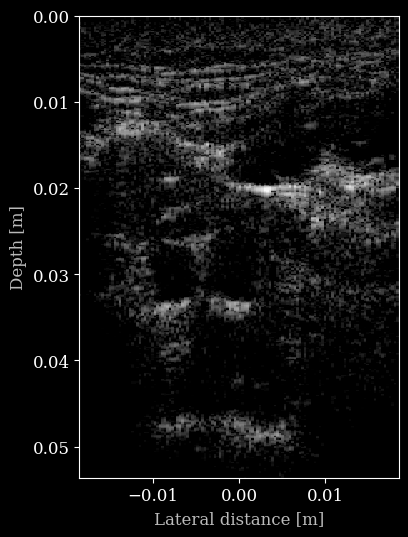

In [ ]:
# Plot the image
set_mpl_style()
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images[0],
          cmap='gray',
          extent=[scan.xlims[0], scan.xlims[1], scan.zlims[1], scan.zlims[0]],
          vmin=config.data.dynamic_range[0], vmax=config.data.dynamic_range[1])

# Add labels
ax.set_xlabel('Lateral distance [m]')
ax.set_ylabel('Depth [m]')

## Comparing to the image stored in the data file
Since this data file also already has processed image data inside we can plot this too and see if the result is the same.

usbmd: WARNING The probe geometry in the data file does not match the probe geometry of the probe. The probe geometry has been updated to match the data file.


Text(0, 0.5, 'Depth [m]')

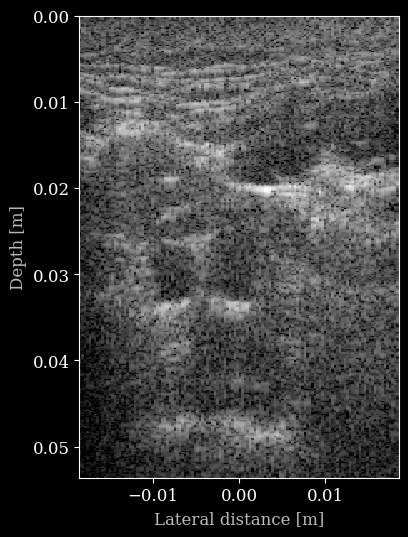

In [15]:
# Load the image data from the data file
data_type = "image"

images = load_usbmd_file(data_path, frames=selected_frames, data_type=data_type, config=config)[0]
image = images[0]

# Apply log compression if data_type is envelope_data
if data_type == "envelope_data":
    normalize = Normalize(output_range=(0, 1), input_range=None)
    log_compress = LogCompress()
    image = normalize(data=image)["data"]
    image = log_compress(data=image, dynamic_range=config.data.dynamic_range)["data"]

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image,
          cmap='gray',
          extent=[scan.xlims[0], scan.xlims[1], scan.zlims[1], scan.zlims[0]])

# Add labels
ax.set_xlabel('Lateral distance [m]')
ax.set_ylabel('Depth [m]')